# Feature Engineering, Feature Selection, Понижение размерности

ДЗ 4 состоит из 10 основных заданий. Темы:
- Feature Engineering: создание, преобразование, масштабирование признаков
- Feature Selection: embedded и wrapper методы, корреляционный анализ
- Понижение размерности: PCA, t-SNE, UMAP

Используйте `breast_cancer` из `sklearn.datasets`. Везде, где это применимо, используйте `train/test split` (80/20).


### Задание 1.Чтение данных (0.5 б)
Загрузите датасет из sklearn и разделите на train и test в соотношении 80/20.

In [ ]:
import pandas as pd

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

In [ ]:
data = load_breast_cancer()

X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name='target')

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

### Задание 2. Логарифмическое преобразование одного признака (1.5 б)
Преобразуйте признак 'mean area' через `FunctionTransformer(np.log1p)` и постройте графики до и после преобразования.
Новый признак назовите 'mean are log', а старый признак 'mean area' удалите после построения графиков.

In [ ]:
import numpy as np
from sklearn.preprocessing import FunctionTransformer

transformer = FunctionTransformer(np.log1p, validate=True)
X_train['mean area log'] = transformer.transform(X_train[['mean area']])
X_test['mean area log']  = transformer.transform(X_test[['mean area']])

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but FunctionTransformer was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but FunctionTransformer was fitted without feature names
  warnings.warn(


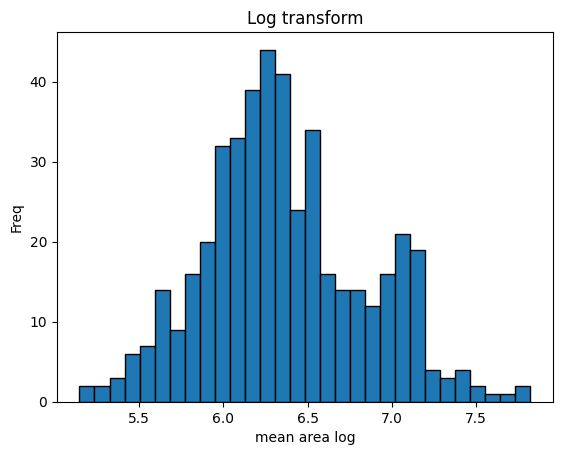

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.hist(X_train['mean area log'], bins=30, edgecolor='k')
plt.xlabel('mean area log')
plt.ylabel('Freq')
plt.title('Log transform')
plt.show()

In [ ]:
X_train.drop(columns=['mean area'], inplace=True)
X_test.drop(columns=['mean area'], inplace=True)

### Задание 3. Масштабирование признаков (0.5 б)
Примените `StandardScaler` к данным. Почему масштабирование важно для некоторых моделей? Оберните отмасштабированные данные обратно в датафреймы.

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
X_train_scaled = pd.DataFrame(
    X_train_scaled,
    columns=X_train.columns,
    index=X_train.index
)

X_test_scaled = pd.DataFrame(
    X_test_scaled,
    columns=X_test.columns,
    index=X_test.index
)

**Ваш ответ:**
- Некоторые модели (например, градиентный спуск, к-средние и тп) чувствительны к разным масштабам признаков - большие значения одного признака могут доминировать в оптимизации или расчёте расстояний и замедлять сходимость или ухудшать качество
- StandardScaler приводит все признаки к нулевому среднему и единичной дисперсии, что обеспечивает более стабильное и справедливое влияние каждого признака


### Задание 4. Создание полиномиальных признаков (2 б)
Создайте полиномиальные признаки степени 2 для первых 5 признаков. Сколько новых признаков получилось?

По шагам:
  - создать полиномиальные фичи из первых 5 признаков для train
  - создать полиномиальные фичи из первых 5 признаков для test
  - обернуть созданые фичи для train в датафрейм
  - обернуть созданые фичи для test в датафрейм
  - применить pd.concat к поли-фичам и фичам с 6ой по последнюю для train
  - применить pd.concat к поли-фичам и фичам с 6ой по последнюю для test

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_first5 = X_train.iloc[:, :5]
X_test_first5  = X_test.iloc[:, :5]

X_train_poly = poly.fit_transform(X_train_first5)
X_test_poly  = poly.transform(X_test_first5)

poly_feature_names = poly.get_feature_names_out(X_train_first5.columns)
X_train_poly_df = pd.DataFrame(X_train_poly,
                               columns=poly_feature_names,
                               index=X_train.index)
X_test_poly_df  = pd.DataFrame(X_test_poly,
                               columns=poly_feature_names,
                               index=X_test.index)

#Сколько новых признаков получилось
print('Фичи:', X_train_poly_df.shape[1])

Фичи: 20


**Ваш ответ:**
- 20



In [ ]:
# Ваш код здесь - аккуратно склеить новые train и test
X_train_final = pd.concat([X_train_poly_df, X_train.iloc[:, 5:]], axis=1)
X_test_final  = pd.concat([X_test_poly_df,  X_test.iloc[:, 5:]], axis=1)

### Задание 5. Корреляционный анализ (1 б)
Постройте матрицу корреляций и удалите признаки с корреляцией > 0.9. Сколько признаков удалено?

In [ ]:
corr_matrix = X_train_final.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.9)]

X_train_reduced = X_train_final.drop(columns=to_drop)
X_test_reduced  = X_test_final.drop(columns=to_drop)

print('Удалено:', len(to_drop))

Удалено: 24


**Ваш ответ:**
- 24


### Задание 6. Отбор признаков с помощью RFE (0.5 б)
Используйте логистическую регрессию и `RFE`, чтобы выбрать 10 признаков для модели. Используйте данные из шага 5.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE

lr = LogisticRegression(random_state=42, max_iter=1000)

rfe = RFE(estimator=lr, n_features_to_select=10)
rfe.fit(X_train_reduced, y_train)

selected_features = X_train_reduced.columns[rfe.support_]
print('Выбранные фичи:', list(selected_features))

X_train_selected = rfe.transform(X_train_reduced)
X_test_selected  = rfe.transform(X_test_reduced)

Выбранные фичи: ['mean compactness', 'mean texture mean smoothness', 'radius error', 'texture error', 'compactness error', 'concavity error', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst symmetry']


### Задание 7. Встроенный метод отбор признаков (1.5 б)
Используйте RandomForest и отберите 10 признаков с наибольшей важностью. Обучите отдельную модель только на отобранных признаках. Как изменилось качество? (выберите метрику самостоятельно)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_reduced, y_train)

y_pred_base = rf.predict(X_test_reduced)
acc_base = accuracy_score(y_test, y_pred_base)
auc_base = roc_auc_score(y_test, rf.predict_proba(X_test_reduced)[:, 1])

importances = dict(zip(X_train_reduced.columns, rf.feature_importances_))
top10 = sorted(importances, key=importances.get, reverse=True)[:10]

rf_top = RandomForestClassifier(random_state=42)
rf_top.fit(X_train_reduced[top10], y_train)

y_pred_top = rf_top.predict(X_test_reduced[top10])
acc_top = accuracy_score(y_test, y_pred_top)
auc_top = roc_auc_score(y_test, rf_top.predict_proba(X_test_reduced[top10])[:, 1])

print('Baseline Accuracy:', acc_base)
print('Top-10 Accuracy:', acc_top)
print('Baseline ROC AUC:', auc_base)
print('Top-10 ROC AUC:', auc_top)
print('Фичи:', top10)

Baseline Accuracy: 0.956140350877193
Top-10 Accuracy: 0.9649122807017544
Baseline ROC AUC: 0.992630199803472
Top-10 ROC AUC: 0.9914837864395676
Фичи: ['mean radius mean texture', 'mean radius', 'worst concavity', 'worst compactness', 'radius error', 'mean compactness', 'mean texture mean smoothness', 'worst symmetry', 'worst smoothness', 'mean texture']


**Ваш ответ:**
- в целом acc подрос, но при этом Roc auc не показал почти никаких изменений

### Задание 8. PCA и визуализация (0.5 б)
Понизьте размерность данных до 2D с помощью PCA. Постройте scatter plot с цветом по y_train.

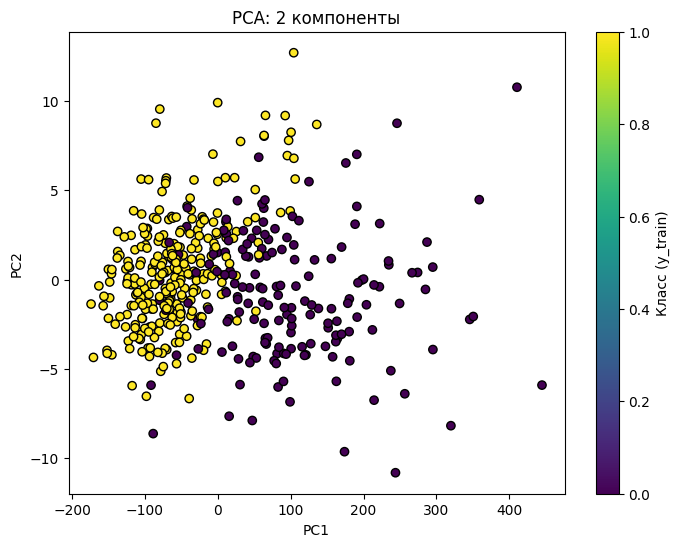

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_reduced)

plt.figure(figsize=(8, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, edgecolor='k', cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA: 2 компоненты')
plt.colorbar(label='Класс (y_train)')
plt.show()

### Задание 9. t-SNE (0.5 б)
Примените t-SNE на train из шага 5. Постройте scatter plot и сравните с PCA.

In [ ]:
from sklearn.manifold import TSNE

# Ваш код здесь


**Ваш ответ:**


### Задание 10. Сравнение PCA, t-SNE, UMAP (1.5 б)
Постройте графики всех трёх методов рядом. Какой лучше разделяет классы?

In [ ]:
# ! conda install umap-learn --y

In [ ]:
import umap.umap_ as umap

# Ваш код здесь


**Ваш ответ:**
